<a href="https://colab.research.google.com/github/krishnagorrepati/DeepLearningProjects/blob/master/Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K   #Impoprting Keras libraries
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Input, Activation, Flatten, Dense, Dropout, Softmax, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils
import tensorflow as tf


In [0]:
from keras.datasets import cifar10    #Importing CIFAR10 from keras 
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data() # loading the CIFAR10 into train and test variables
num_train, img_channels, img_rows, img_cols =  train_features.shape #Setting number of image channels, coloums, rows
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

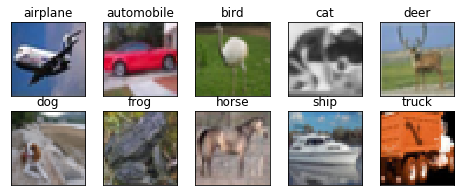

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',  # Plotting 10 images of different classes present in CIFAR10
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):                   #Function to plot the graph of accuracy and loss
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255           #Dividing the train and test data by color range of the image
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x1(Layer1):
    return tf.space_to_depth(Layer1, block_size=2)
def space_to_depth_x4(Layer4):
    return tf.space_to_depth(Layer4, block_size=2)
def space_to_depth_x3(Layer3):
    return tf.space_to_depth(Layer3, block_size=2)
def space_to_depth_x6(Layer6):
    return tf.space_to_depth(Layer6, block_size=2)
def space_to_depth_x7(Layer7):
    return tf.space_to_depth(Layer7, block_size=2)
def space_to_depth_x2(Layer2):
    return tf.space_to_depth(Layer2, block_size=4)
def space_to_depth_x5(Layer5):
    return tf.space_to_depth(Layer5, block_size=2)

input=Input(shape=(32, 32, 3))

Layer1=SeparableConv2D(16, 5, 5, border_mode='same', activation='relu', name='layer1')(input)
Layer1=BatchNormalization()(Layer1)
Layer1=Dropout(0.20)(Layer1)

Layer2=Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='layer2')(Layer1)
Layer2=BatchNormalization()(Layer2)
Layer2=Dropout(0.20)(Layer2)

Layer3=Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='layer3')(Layer2)
Layer3=BatchNormalization()(Layer3)
Layer3=Dropout(0.20)(Layer3)


Layer4=SeparableConv2D(128, 5, 5,border_mode='same', activation='relu', name='layer4')(concatenate([Layer1, Layer3]))
Layer4=BatchNormalization()(Layer4)
Layer4=Dropout(0.20)(Layer4)

Maxpool1=MaxPooling2D(2, 2, name='Maxpool1')(concatenate([Layer1,Layer4]))

Layer5=SeparableConv2D(16, 3, 3, border_mode='same', activation='relu', name='layer5')(Maxpool1)
Layer5=BatchNormalization()(Layer5)
Layer5=Dropout(0.20)(Layer5)

Layer1=Lambda(space_to_depth_x1)(Layer1)
Layer4=Lambda(space_to_depth_x4)(Layer4)
Layer6=Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='layer6')(concatenate([Layer1, Layer4, Layer5]))
Layer6=BatchNormalization()(Layer6)
Layer6=Dropout(0.20)(Layer6)

Layer3=Lambda(space_to_depth_x3)(Layer3)
Layer7=SeparableConv2D(128, 3, 3, border_mode='same', activation='relu', name='layer7')(concatenate([Layer3, Layer4, Layer5, Layer6]))
Layer7=BatchNormalization()(Layer7)
Layer7=Dropout(0.20)(Layer7)

Layer8=SeparableConv2D(256, 5, 5, border_mode='same', activation='relu', name='layer8')(concatenate([Layer1, Layer3, Layer4, Layer5, Layer6, Layer7]))
Layer8=BatchNormalization()(Layer8)
Layer8=Dropout(0.20)(Layer8)

Maxpool2=MaxPooling2D(2, 2, name='Maxpool2')(concatenate([Layer1, Layer4, Layer5, Layer7, Layer8]))

Layer6=Lambda(space_to_depth_x6)(Layer6)
Layer9=Convolution2D(16, 5, 5, border_mode='same', activation='relu', name='layer9')(concatenate([Layer6, Maxpool2]))
Layer9=BatchNormalization()(Layer9)
Layer9=Dropout(0.20)(Layer9)

Layer1=Lambda(space_to_depth_x1)(Layer1)
Layer4=Lambda(space_to_depth_x4)(Layer4)
Layer7=Lambda(space_to_depth_x7)(Layer7)
Layer2=Lambda(space_to_depth_x2)(Layer2)
Layer10=SeparableConv2D(32, 5, 5, border_mode='same', activation='relu', name='layer10')(concatenate([Layer1, Layer2, Layer4, Layer7, Layer9]))
Layer10=BatchNormalization()(Layer10)
Layer10=Dropout(0.20)(Layer10)

Layer3=Lambda(space_to_depth_x3)(Layer3)
Layer5=Lambda(space_to_depth_x5)(Layer5)
Layer11=Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='layer11')(concatenate([Layer2, Layer3, Layer5, Layer9, Layer10]))
Layer11=BatchNormalization()(Layer11)
Layer11=Dropout(0.20)(Layer11)

Layer12=SeparableConv2D(128, 5, 5, border_mode='same', activation='relu', name='layer12')(concatenate([Layer3, Layer4, Layer5, Layer7, Layer10, Layer11]))
Layer12=BatchNormalization()(Layer12)
Layer12=Dropout(0.20)(Layer12)

Finalconv=Convolution2D(10, 8, 8,  name='Finalconv')(concatenate([Layer4, Layer7, Layer10, Layer12]))
Finalconv=Flatten()(Finalconv)

#output=Activation('softmax')(concatenate([Layer4, Layer7, Layer10, Layer12]))
output=Activation('softmax')(Finalconv)

model = Model(inputs=[input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(16, (5, 5), activation="relu", name="layer1", padding="same")`
W0623 08:38:28.725476 140073559897984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0623 08:38:28.807670 140073559897984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
layer1 (SeparableConv2D)        (None, 32, 32, 16)   139         input_41[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          layer1[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
layer2 (Co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8), name="Finalconv")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  del sys.path[0]


Epoch 1/50
390/390 [==============================] - 100s 256ms/step - loss: 3.0537 - acc: 0.3899 - val_loss: 1.9524 - val_acc: 0.4171
Epoch 2/50
390/390 [==============================] - 94s 241ms/step - loss: 1.5058 - acc: 0.5251 - val_loss: 1.3760 - val_acc: 0.5306
Epoch 3/50
390/390 [==============================] - 94s 240ms/step - loss: 1.3250 - acc: 0.5807 - val_loss: 1.2018 - val_acc: 0.5977
Epoch 4/50
390/390 [==============================] - 93s 239ms/step - loss: 1.3026 - acc: 0.6010 - val_loss: 1.3740 - val_acc: 0.5646
Epoch 5/50
390/390 [==============================] - 93s 239ms/step - loss: 1.1190 - acc: 0.6523 - val_loss: 1.2045 - val_acc: 0.6094
Epoch 6/50
390/390 [==============================] - 93s 239ms/step - loss: 1.0381 - acc: 0.6847 - val_loss: 1.1330 - val_acc: 0.6273
Epoch 7/50
390/390 [==============================] - 93s 239ms/step - loss: 0.9651 - acc: 0.7036 - val_loss: 1.1981 - val_acc: 0.6167
Epoch 8/50
390/390 [==============================] - 

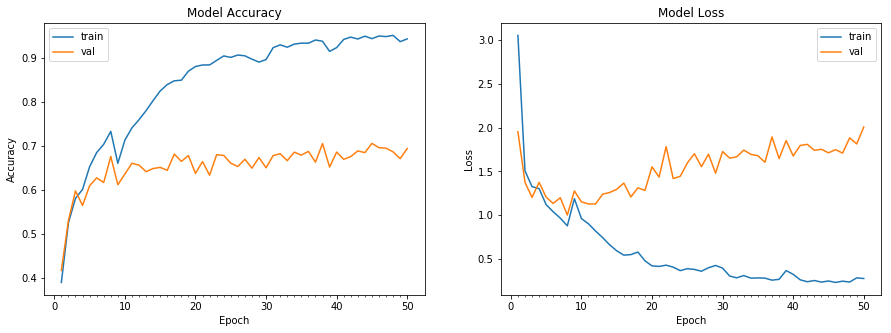

Accuracy on test data is: 69.40


In [0]:

from keras.preprocessing.image import ImageDataGenerator # Imagedatagenerator library is used for data augmentation with no horizontal flips

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
390/390 [==============================] - 93s 239ms/step - loss: 0.2402 - acc: 0.9473 - val_loss: 2.2079 - val_acc: 0.6721
Epoch 2/50
390/390 [==============================] - 93s 239ms/step - loss: 0.2165 - acc: 0.9528 - val_loss: 1.9319 - val_acc: 0.6887
Epoch 3/50
390/390 [==============================] - 93s 239ms/step - loss: 0.2313 - acc: 0.9501 - val_loss: 2.2034 - val_acc: 0.6816
Epoch 4/50
390/390 [==============================] - 93s 238ms/step - loss: 0.2809 - acc: 0.9349 - val_loss: 2.0000 - val_acc: 0.6520
Epoch 5/50
390/390 [==============================] - 93s 239ms/step - loss: 0.2392 - acc: 0.9474 - val_loss: 1.9512 - val_acc: 0.6807
Epoch 6/50
390/390 [==============================] - 93s 239ms/step - loss: 0.1964 - acc: 0.9595 - val_loss: 1.8676 - val_acc: 0.6902
Epoch 7/50
390/390 [==============================] - 94s 240ms/step - loss: 0.2043 - acc: 0.9587 - val_loss: 1.9693 - val_acc: 0.6907
Epoch 8/50
390/390 [==============================] - 9

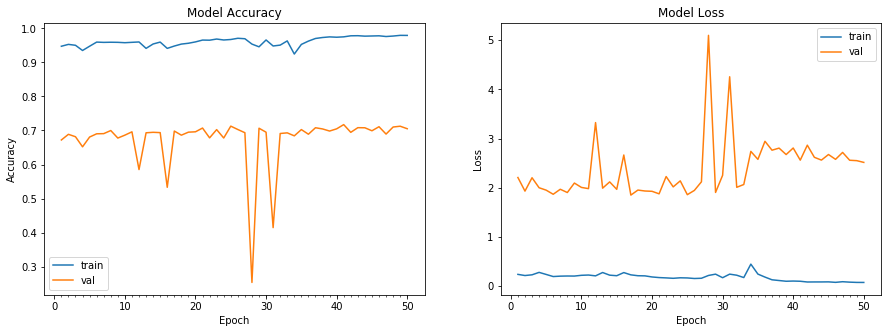

Accuracy on test data is: 70.51


In [0]:
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))